In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt 
import re
import seaborn as sns
import numpy as np
from modules.neighbor_loader import LastNeighborLoaderTGNPL
from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset, PyGLinkPropPredDatasetHyper
from modules.emb_module import *
from modules.time_enc import TimeEncoder
from sklearn.metrics import precision_recall_curve

In [2]:
data = pd.read_table(f'./data/observed_transactions.psv', sep="|")
NUM_FIRMS = len(set(data['origin_company']).union(set(data['dest_company'])))
NUM_PRODUCTS = len(set(data['product']))
NUM_NODES = NUM_FIRMS+NUM_PRODUCTS
print(f"There are {NUM_FIRMS} firms and {NUM_PRODUCTS} products")
min(set(data['product'])), max(set(data['product'])), len(set(data['product']))

There are 21 firms and 97 products


('product0', 'product99', 97)

In [3]:
# Detect missing products
prod_before2after, prod_after2before = {}, {}
missing_prods = []
cnt = 0
for i in range(100):
    target_str = f"product{i}"
    if target_str not in set(data['product']):
        print(f"{target_str} is missing")
        missing_prods.append(target_str)
        continue
    prod_before2after[f"product{i}"] = f"product{cnt}"
    prod_after2before[f"product{cnt}"] = f"product{i}"
    cnt += 1
missing_prods

product26 is missing
product78 is missing
product93 is missing


['product26', 'product78', 'product93']

## Get ground-truth BOM? 

In [4]:
# Read in overall psv
df = pd.read_table(f'./data/production_fn.psv', sep= "|") 
print(f"Import production_fn.psv as df with shape {df.shape}")

# Filter out relationships with missing_prods
f = df['product'].str.contains('|'.join(missing_prods)) | df['prod_func'].str.contains('|'.join(missing_prods))
df = df[~f]
print(f"df shape after filtering out missing products {df.shape}")
df.iloc[0]["prod_func"]

Import production_fn.psv as df with shape (280, 2)
df shape after filtering out missing products (269, 2)


'0.734(company1-product23)+ 0.881(company16-product20)+ 0.588(company16-product12)+ 0.432(company0-product57)+ 0.201(company3-product85)+ 0.785(company3-product99)'

In [5]:
# Apply new mapping to products
for before_prod, after_prod in prod_before2after.items():
    # note: since we replace prod_x with prod_y (y<=x), so there'll NOT be repeated replacement of the same str
    df['product'] = df['product'].str.replace(before_prod, after_prod)
    df['prod_func'] = df['prod_func'].str.replace(before_prod, after_prod)
df.iloc[0]["prod_func"]

'0.734(company1-product23)+ 0.881(company16-product20)+ 0.588(company16-product12)+ 0.432(company0-product56)+ 0.201(company3-product83)+ 0.785(company3-product96)'

In [6]:
# Recognize relationship type
nonlinear_op_matches= ["ExoProd", "^", "/"] # "min" and "/" appear together, "^" and "x" appear together
for op_match in nonlinear_op_matches:
    df[op_match] = [sum([op_match in value])>0 for value in df["prod_func"]]
df["linear"] = [sum([op in value for op in nonlinear_op_matches])==0 for value in df["prod_func"]]
df.head()

,product,prod_func,ExoProd,^,/,linear
1,company0-product87,0.734(company1-product23)+ 0.881(company16-pro...,False,False,False,True
2,company0-product18,2.848174813753853 x (company16-product61)^0.48...,False,True,False,False
3,company0-product92,min{(company5-product25)/0.386},False,False,True,False
4,company0-product64,0.488(company0-product43)+ 0.279(company12-pro...,False,False,False,True
5,company0-product23,ExoProd[0.0087],True,False,False,False


In [7]:
# Regex handling to elicit company, supply_prod, list of buy_prod from strings for later use
company_lambda = lambda row: int(re.split('company|-product', row["product"])[1])
supply_prod_lambda = lambda row: int(re.split('company|-product', row["product"])[2])
buy_prod_list_lambda = lambda row: [int(p) for p in re.split('product|\)', row["prod_func"])[1::2]]

df["company"] = df.apply(company_lambda, axis=1)
df["supply_prod"] = df.apply(supply_prod_lambda, axis=1)
df["buy_prod_list"] = df.apply(buy_prod_list_lambda, axis=1)
df['buy_prod_list_len'] = df['buy_prod_list'].apply(len)


print(f"After preprocessing, df has shape {df.shape}")
df.head()

After preprocessing, df has shape (269, 10)


,product,prod_func,ExoProd,^,/,linear,company,supply_prod,buy_prod_list,buy_prod_list_len
1,company0-product87,0.734(company1-product23)+ 0.881(company16-pro...,False,False,False,True,0,87,"[23, 20, 12, 56, 83, 96]",6
2,company0-product18,2.848174813753853 x (company16-product61)^0.48...,False,True,False,False,0,18,"[61, 5]",2
3,company0-product92,min{(company5-product25)/0.386},False,False,True,False,0,92,[25],1
4,company0-product64,0.488(company0-product43)+ 0.279(company12-pro...,False,False,False,True,0,64,"[43, 58, 46]",3
5,company0-product23,ExoProd[0.0087],True,False,False,False,0,23,[],0


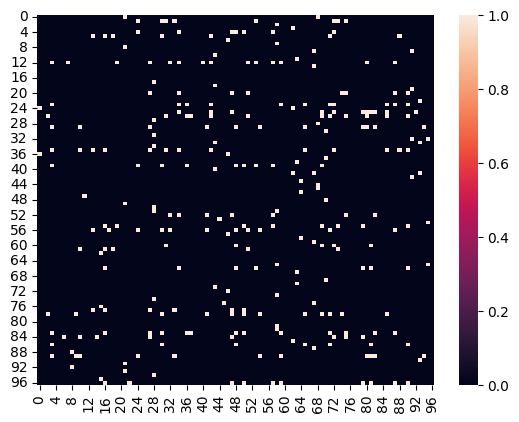

In [8]:
# Construct true attention matrix
am_true = np.zeros([NUM_PRODUCTS, NUM_PRODUCTS]) # a_{buy_prod, supply_prod}
for idx, row in df.iterrows():
    supply_prod = row['supply_prod']
    buy_prod_list = row['buy_prod_list']
    for buy_prod in buy_prod_list:
        am_true[buy_prod][supply_prod] = 1 
    # Note: recall that a_{kl} represents use prod k (buy) to produce prod l (supply)

sns.heatmap(am_true, annot=False, fmt=".1f")
plt.show()

## Static Attention Matrix Analysis

In [9]:
# Helper function copied from tgnpl.py
def repeat_tensor(t, k):
    """
    When k = 2, tensor([1, 2, 3]) becomes tensor([1, 1, 2, 2, 3, 3]).
    Used to align the ordering of neighbor loader 'e_id' and data
    """
    if len(t.shape)==1:
        return t.reshape(-1, 1).repeat(1, k).reshape(t.shape[0]*k)
    elif len(t.shape)==2:
        return t.reshape(-1, 1).repeat(1, k).reshape(t.shape[0]*k, 1)
    else:
        raise Exception("repeat_tensor: Not Applicable")
        
def get_static_attention_matrix(model, emb_dim=100):
    p_id = range(NUM_FIRMS, NUM_FIRMS+NUM_PRODUCTS) # all product IDs
    
    # calculate prod_embs
    if len(static_inv['gnn'])==0: # when gnn is IdentityFunction()
        prod_embs = model['memory']['memory.weight'][p_id].cpu() # [num_products x emb_dim]
    else: # when gnn is GraphAttentionEmbedding()
        device = 'cuda'
        dataset = PyGLinkPropPredDatasetHyper(name="tgbl-hypergraph_synthetic", root="datasets", 
                                          use_prev_sampling = True)
        data = dataset.get_TemporalData().to(device)

        # Helper vector to map global node indices to local ones
        assoc = torch.empty(NUM_NODES, dtype=torch.long, device=device)
        # get product embeddings
        f_id = torch.Tensor([]).long().to(device)  # we only need embeddings for products, not firms
        p_id = torch.arange(NUM_FIRMS, NUM_FIRMS+NUM_PRODUCTS, device=device).long()  # all product IDs
        n_id, edge_index, e_id = model['neighbor_loader'](f_id, p_id)  # n_id contains p_id and its neighbors
        assoc[n_id] = torch.arange(n_id.size(0), device=device)  # maps original ID to row in z
        memory, last_update, update_loss = model['memory']['memory.weight'][n_id], model['memory']['last_update'][n_id], 0
        gnn = GraphAttentionEmbedding(emb_dim, emb_dim, 1, TimeEncoder(100)).to(device) # assume mem_dim, emb_dim, time_dim=100; msg_dim=1
        gnn.load_state_dict(model['gnn'])
        z = gnn(
            memory,
            last_update,
            edge_index,
            repeat_tensor(data.t, 2)[e_id].to(device),
            repeat_tensor(data.msg, 2)[e_id].to(device),
        )
        prod_embs = z[assoc[p_id]].detach().cpu() # [num_products x emb_dim]
        
    prod_bilinear = model['inventory']['prod_bilinear'].cpu() # [emb_dim x emb_dim]
    att_weights = prod_embs @ (prod_bilinear @ prod_embs.T)
    return torch.nn.ReLU(inplace=False)(att_weights).cpu()

In [10]:
# STATIC + ID load in best vs final
MODEL_DIR = "/lfs/local/0/zhiyinl/supply-chains/TGB/examples/linkproppred/general/saved_models/"
MODEL_NAME = "TGNPL_tgbl-hypergraph_synthetic_0.0001_200_10_100_1_100_100_100_1e-06_100.0_1_False_True_False_static_id_True_5.0_1_1_0_-1_False_False_2024_01_29-00_15_50"
static_inv = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0.pth")
static_inv_final = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_final.pth")
print(static_inv['inventory'].keys(), static_inv_final['inventory'].keys())

odict_keys(['prod_bilinear']) odict_keys(['prod_bilinear'])


In [11]:
# Get attention matrix: best (epoch 12) vs final (epoch 99)
am_bstatic = get_static_attention_matrix(static_inv)
print(f"Best static attention matrix has max {am_bstatic.max()} and min {am_bstatic.min()} and shape {am_bstatic.shape}")

am_fstatic = get_static_attention_matrix(static_inv_final)
print(f"Final static attention matrix has max {am_fstatic.max()} and min {am_fstatic.min()} and shape {am_fstatic.shape}")

Best static attention matrix has max 68.27583312988281 and min 0.0 and shape torch.Size([97, 97])
Final static attention matrix has max 44.707698822021484 and min 0.0 and shape torch.Size([97, 97])


Below is static best attention matrix


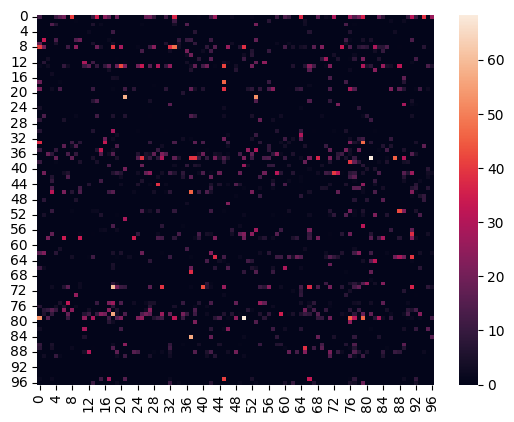

Below is static final attention matrix


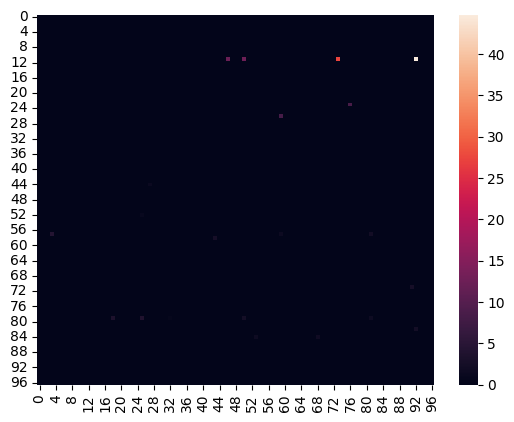

In [12]:
# Heatmap Visualization
print("Below is static best attention matrix")
sns.heatmap(am_bstatic, annot=False, fmt=".1f")
plt.show()

print("Below is static final attention matrix")
sns.heatmap(am_fstatic, annot=False, fmt=".1f")
plt.show()

### Evaluation

In [13]:
# Precision recall curve
def plot_precision_recall_curve(am_true, am_pred, label=""):
    precision, recall, thresholds = precision_recall_curve(am_true.flatten(), am_pred.flatten())
    plt.figure(figsize=(4,2))
    plt.plot(recall, precision)  
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title(f"precision vs. recall curve for {label}")
    plt.show()

In [14]:
# Ranking curve: for each supply prod, how many are ranked top THRESHOLD (default: # shown up in prod_func)
# Note: recall attention matrix is of this form a_{buy_prod, supply_prod}
MAX = 150
def get_rankings(am_true, am_pred):
    true_rankings, pred_rankings = [], []
    for supply_prod in range(NUM_PRODUCTS):

        y_true = am_true[:,supply_prod] # always 0, 1
        y_pred = am_pred[:,supply_prod]

        sorted_true = sorted(range(len(y_true)), key=lambda k: y_true[k], reverse=True) # sort the index
        sorted_pred = sorted(range(len(y_pred)), key=lambda k: y_pred[k], reverse=True)
        COUNT = int(sum(y_true)) # buy products that has true production relationship with the fixed supply prod

        # for every true, get the ranking of the value in pred
        rankings = []
        for true_value in sorted_true[:COUNT]:
            rankings.append(sorted_pred.index(true_value))
        true_rankings.append(sum(range(COUNT)) / COUNT if COUNT > 0 else MAX) # avg true ranking
        # we care about pred_rankings
        pred_rankings.append(sum(rankings) / len(rankings) if len(rankings) > 0 else MAX) # avg pred ranking
    return true_rankings, pred_rankings

def plot_rankings(am_true, am_pred, label=""):
    true_rankings, pred_rankings = get_rankings(am_true, am_bstatic)
    plt.figure(figsize=(6,6))
    plt.scatter(range(NUM_PRODUCTS), true_rankings, color="r", label="true ranking")  
    plt.scatter(range(NUM_PRODUCTS), pred_rankings, color="b", label="pred ranking")  
    plt.xlabel("supply product")
    plt.ylabel("average ranking")
    plt.title(f"true vs pred ranking curve for {label}") # the lower the better
    plt.show()

In [15]:
# # Evaluate with precision + recall curve
# plot_precision_recall_curve(am_true, am_bstatic, "static+id (best)")

# # Evaluate with ranking
# plot_rankings(am_true, am_bstatic, "static+id (best)")

(successful pred) buy, supply prod are 0, 68 with distance -1 
(successful pred) buy, supply prod are 1, 72 with distance 0 
(successful pred) buy, supply prod are 4, 34 with distance -2 
(successful pred) buy, supply prod are 4, 47 with distance 0 
(successful pred) buy, supply prod are 12, 53 with distance 0 
(successful pred) buy, supply prod are 13, 67 with distance -5 
(successful pred) buy, supply prod are 26, 80 with distance -4 
(successful pred) buy, supply prod are 35, 85 with distance -4 
(successful pred) buy, supply prod are 39, 50 with distance -5 
(successful pred) buy, supply prod are 39, 57 with distance -2 
(successful pred) buy, supply prod are 39, 69 with distance 0 
(successful pred) buy, supply prod are 41, 62 with distance -3 
(successful pred) buy, supply prod are 52, 75 with distance -5 
(successful pred) buy, supply prod are 52, 82 with distance -2 
(successful pred) buy, supply prod are 55, 79 with distance -3 
(successful pred) buy, supply prod are 75, 67 wi

/lfs/local/0/zhiyinl/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:985: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


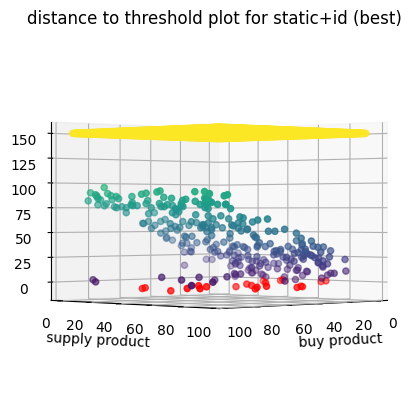

In [16]:
# Distance to threshold: for each supply prod, how far it is its ranking to the THRESHOLD
# - positive is bad, negative is good
# - 3D plot: (buy_prod, supply_prod, dist)
# Note: recall attention matrix is of this form a_{buy_prod, supply_prod}
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
    
MAX = 150
def get_dist2threshold(am_true, am_pred):
    dist_dict = {}
    for supply_prod in range(NUM_PRODUCTS):
        y_true = am_true[:,supply_prod] # always 0, 1
        y_pred = am_pred[:,supply_prod]
        sorted_true = sorted(range(len(y_true)), key=lambda k: y_true[k], reverse=True) # sort the index
        THRESHOLD = int(sum(y_true)) # buy products that has true production relationship with the fixed supply prod
        if THRESHOLD==0: continue
        sorted_pred = sorted(range(len(y_pred)), key=lambda k: y_pred[k], reverse=True)

        # for every true, get the ranking of the true buy prod in pred
        for true_buy_prod in sorted_true[:THRESHOLD]:
            ranking = sorted_pred.index(true_buy_prod)
            dist = ranking - THRESHOLD
            dist_dict[(true_buy_prod, supply_prod)] = dist
         
    return dist_dict

def plot_dist2threshold(am_true, am_pred, label=""):
    # process data
    dist_dict = get_dist2threshold(am_true, am_pred)
    x_list, y_list, dist_list = [], [], []
    correct_pred = []
    for buy_prod in range(NUM_PRODUCTS):
        for supply_prod in range(NUM_PRODUCTS):
            dist = dist_dict.get((buy_prod, supply_prod), MAX) 
            if dist <= 0:
                print(f"(successful pred) buy, supply prod are {buy_prod}, {supply_prod} with distance {dist} ")
                correct_pred.append((buy_prod, supply_prod))
            x_list.append(buy_prod)
            y_list.append(supply_prod)
            dist_list.append(dist)
    # plot figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Use a colormap for continuous color change
    norm = plt.Normalize(min(dist_list), max(dist_list))
    colors = plt.cm.viridis(norm(dist_list))
    colors = ['red' if z <= 0 else colors[i] for i, z in enumerate(dist_list)]
    ax.scatter(x_list, y_list, dist_list, c=colors, marker='o')
    
    ax.set_xlabel('buy product')
    ax.set_ylabel('supply product')
    ax.set_zlabel('distance (<=0 within threshold)')
    ax.set_title(f"distance to threshold plot for {label}") # the lower the better
    ax.view_init(elev=0, azim=45)
    return correct_pred
    
# We marked accurate attention matrix predictions with red (i.e. distance <= 0)
correct_pred = plot_dist2threshold(am_true, am_bstatic, "static+id (best)")

# Except for the identified points, other points show linear trend wrt buy product. 
# This is expected because we sort the pred linearly and tie break by smallest first when the pred is the same.



### What are some separating characteristics of these correct predictions (red dots)? 

In [17]:
correct_pred

[(0, 68),
 (1, 72),
 (4, 34),
 (4, 47),
 (12, 53),
 (13, 67),
 (26, 80),
 (35, 85),
 (39, 50),
 (39, 57),
 (39, 69),
 (41, 62),
 (52, 75),
 (52, 82),
 (55, 79),
 (75, 67),
 (77, 27),
 (78, 30),
 (78, 47),
 (78, 65),
 (84, 72),
 (87, 67)]

Text(0.5, 1.0, 'product vs frequency (red correct, blue incorrect predictions)')

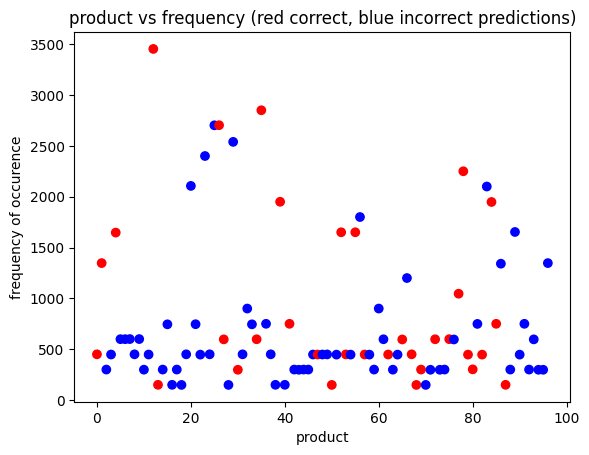

In [18]:
# Guess 1: they have a lot of data

# get occurence frequencies of (buy_prod, supply_prod) pairs
correct_products = {value for tuple_item in correct_pred for value in tuple_item}
data = pd.read_table(f'./data/observed_transactions.psv', sep="|")
freq_dict = data['product'].value_counts().to_dict()

y_values, colors = [], []
for i in range(NUM_PRODUCTS):
    product = prod_after2before[f"product{i}"] # since data is NOT processed w missing value
    freq = freq_dict[product]
    y_values.append(freq)
    colors.append("red" if i in correct_products else "blue")
plt.scatter(range(NUM_PRODUCTS), y_values, c=colors)
plt.xlabel("product")
plt.ylabel("frequency of occurence")
plt.title("product vs frequency (red correct, blue incorrect predictions)")

In [19]:
# Guess 2: they have high correlations

# plot out all correlations in 3D graph. X, Y-axis are buy prod, supply prod and Z is corr 
def get_correlation():
    x_list, y_list, corr_list = [], [], []
    for COMPANY in range(21):
        result_df = pd.read_csv(f'./result/result{COMPANY}.csv') 
        result_df = result_df.fillna(-1)
        result_df = result_df.loc[result_df.groupby(['BUY_PROD', 'SUPPLY_PROD'], sort=False).r.idxmax()]

        for index, row in result_df.iterrows():
            supply_id = int(row.BUY_PROD)
            buy_id = int(row.SUPPLY_PROD)
            supply_prod = int(prod_before2after[f"product{supply_id}"].replace('product', ''))
            buy_prod = int(prod_before2after[f"product{buy_id}"].replace('product', ''))
            x_list.append(buy_prod)
            y_list.append(supply_prod)
            if (buy_prod, supply_prod) in correct_pred:
                print(f"buy, supply prod {(buy_prod, supply_prod)} has corr {row.r}")
            corr_list.append(row.r)
    return x_list, y_list, corr_list

buy, supply prod (1, 72) has corr 0.8729074200910303
buy, supply prod (4, 47) has corr 0.4226768263910205
buy, supply prod (78, 47) has corr 0.5888245010156731
buy, supply prod (78, 65) has corr 0.8356988149724403
buy, supply prod (84, 72) has corr 0.9184269316839876
buy, supply prod (84, 72) has corr 0.9184269316839876
buy, supply prod (35, 85) has corr 0.8441482755043451
buy, supply prod (35, 85) has corr 0.8441482755043451
buy, supply prod (1, 72) has corr 0.8729074200910303
buy, supply prod (1, 72) has corr 0.8729074200910303
buy, supply prod (1, 72) has corr 0.8729074200910303
buy, supply prod (35, 85) has corr 0.8441482755043451
buy, supply prod (35, 85) has corr 0.8441482755043451


/lfs/local/0/zhiyinl/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:985: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


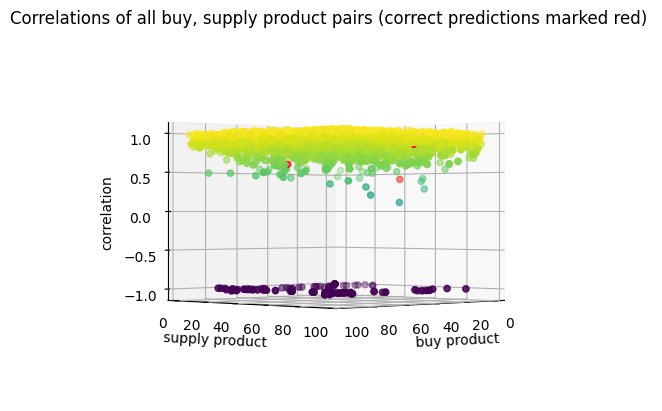

In [20]:
def plot_correlation(label):
    x_list, y_list, corr_list = get_correlation()
    
    # plot figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Use a colormap for continuous color change
    norm = plt.Normalize(min(corr_list), max(corr_list))
    colors = plt.cm.viridis(norm(corr_list))
    colors = ['red' if (buy_prod, supply_prod) in correct_pred else colors[i] for i, (buy_prod, supply_prod) in enumerate(zip(x_list, y_list))]
    ax.scatter(x_list, y_list, corr_list, c=colors, marker='o')

    ax.set_xlabel('buy product')
    ax.set_ylabel('supply product')
    ax.set_zlabel('correlation')
    ax.set_title(f"Correlations of all buy, supply product pairs (correct predictions marked red) {label}") # the lower the better
    ax.view_init(elev=0, azim=45)
plot_correlation("")

In [21]:
# Guess 3: type of relationship
# Take-away: ExoProd's never correct lol .. linear is the easiest to capture
correct_relation_df = pd.DataFrame()  # Initialize an empty DataFrame for concatenation
for (buy_id, supply_id) in correct_pred:
    buy_prod = f"product{buy_id}"
    supply_prod = f"product{supply_id}"
    filtered_rows = df[df['product'].str.contains(supply_prod) & df['prod_func'].str.contains(buy_prod)]    
    correct_relation_df = pd.concat([correct_relation_df, filtered_rows], ignore_index=True)
correct_relation_df.head()

,product,prod_func,ExoProd,^,/,linear,company,supply_prod,buy_prod_list,buy_prod_list_len
0,company11-product68,"min{(company16-product45)/0.553, (company17-pr...",False,False,True,False,11,68,"[45, 0, 28, 44]",4
1,company0-product72,5.397246918054542 x (company11-product23)^0.13...,False,True,False,False,0,72,"[23, 84, 1, 35, 60, 25, 4]",7
2,company3-product72,0.290(company11-product23)+ 0.401(company1-pro...,False,False,False,True,3,72,"[23, 35, 84, 1, 60, 4, 25]",7
3,company1-product34,"min{(company1-product23)/0.223, (company16-pro...",False,False,True,False,1,34,"[23, 12, 66, 25, 52, 20, 4, 35]",8
4,company10-product34,"min{(company11-product23)/0.607, (company16-pr...",False,False,True,False,10,34,"[23, 20, 25, 12, 66, 4, 52, 35]",8


In [24]:
# Some statistics of relationship type

# This considers correct predictions' relations (red dots)
LEN = correct_relation_df.shape[0]
print("Percent of ExoProd", correct_relation_df["ExoProd"].sum()/LEN)
print("Percent of ^", correct_relation_df["^"].sum()/LEN)
print("Percent of /", correct_relation_df["/"].sum()/LEN)
print("Percent of linear", correct_relation_df["linear"].sum()/LEN)
correct_relation_df.describe()

Percent of ExoProd 0.0
Percent of ^ 0.3142857142857143
Percent of / 0.24285714285714285
Percent of linear 0.44285714285714284


,company,supply_prod,buy_prod_list_len
count,70.000000,70.000000,70.000000
mean,9.757143,61.885714,6.200000
std,6.393919,16.938544,1.136993
min,0.000000,27.000000,4.000000
25%,3.000000,47.750000,6.000000
50%,11.000000,67.000000,6.000000
75%,16.000000,75.000000,7.000000
max,19.000000,85.000000,8.000000


In [25]:
# Baseline for reference: this considers all predictions' relations

LEN = df.shape[0]
print("Percent of ExoProd", df["ExoProd"].sum()/LEN)
print("Percent of ^", df["^"].sum()/LEN)
print("Percent of /", df["/"].sum()/LEN)
print("Percent of linear", df["linear"].sum()/LEN)
df.describe()

Percent of ExoProd 0.26765799256505574
Percent of ^ 0.20817843866171004
Percent of / 0.22304832713754646
Percent of linear 0.30111524163568776


,company,supply_prod,buy_prod_list_len
count,269.000000,269.000000,269.000000
mean,8.706320,46.903346,3.089219
std,6.126709,28.919567,2.652694
min,0.000000,0.000000,0.000000
25%,3.000000,21.000000,0.000000
50%,9.000000,45.000000,3.000000
75%,14.000000,74.000000,5.000000
max,19.000000,96.000000,8.000000


## Archive - Some Non-informative Experiments

In [ ]:
# What about plotting for the model every ten epochs? 
for epoch in range(10, 101, 10):
    # STATIC + ID at this epoch
    static_epoch = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_{epoch}.pth")
    am_estatic = get_static_attention_matrix(static_epoch)
    # plot_precision_recall_curve(am_true, am_estatic, f"static+id (epoch {epoch})")
    plot_rankings(am_true, am_estatic, f"static+id (epoch {epoch})")
    
# The performance seems to be good at the start and gets worse as we train for more epochs

In [ ]:
# What about static+id with mem_dim, emb_dim=1000? 
# STATIC + ID load in best vs final
MODEL_DIR = "/lfs/local/0/zhiyinl/supply-chains/TGB/examples/linkproppred/general/saved_models/"
MODEL_NAME = "TGNPL_tgbl-hypergraph_synthetic_0.0001_200_10_100_1_1000_100_1000_1e-06_100.0_1_False_True_False_static_attn_True_5.0_1_1_0_-1_False_False_2024_01_29-00_16_08"
static_inv = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0.pth")
static_inv_final = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_final.pth")
print(static_inv['inventory'].keys(), static_inv_final['inventory'].keys())

# Get attention matrix: best (epoch 12) vs final (epoch 99)
am_bstatic = get_static_attention_matrix(static_inv, emb_dim=1000)
print(f"Best static attention matrix has max {am_bstatic.max()} and min {am_bstatic.min()} and shape {am_bstatic.shape}")

am_fstatic = get_static_attention_matrix(static_inv_final, emb_dim=1000)
print(f"Final static attention matrix has max {am_fstatic.max()} and min {am_fstatic.min()} and shape {am_fstatic.shape}")

# Heatmap Visualization
print("Below is static best attention matrix")
sns.heatmap(am_bstatic, annot=False, fmt=".1f")
plt.show()

print("Below is static final attention matrix")
sns.heatmap(am_fstatic, annot=False, fmt=".1f")
plt.show()

# Evaluate with precision + recall curve
plot_precision_recall_curve(am_true, am_bstatic, "static+id (best)")
plot_precision_recall_curve(am_true, am_fstatic, "static+id (final)")

# Evaluate with ranking
plot_rankings(am_true, am_bstatic, "static+id (best)")
plot_rankings(am_true, am_bstatic, "static+id (final)")

# Conclusion: This helps a bit

In [ ]:
# What about static+attn?
# STATIC + attn load in best vs final
MODEL_DIR = "/lfs/local/0/zhiyinl/supply-chains/TGB/examples/linkproppred/general/saved_models/"
MODEL_NAME = "TGNPL_tgbl-hypergraph_synthetic_0.0001_200_10_100_1_100_100_100_1e-06_100.0_1_False_True_False_static_attn_True_5.0_1_1_0_-1_False_False_2024_01_29-00_16_12"
static_inv = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0.pth")
static_inv_final = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_final.pth")
print(static_inv['inventory'].keys(), static_inv_final['inventory'].keys())

# Get attention matrix: best (epoch 12) vs final (epoch 99)
am_bstatic = get_static_attention_matrix(static_inv)
print(f"Best static attention matrix has max {am_bstatic.max()} and min {am_bstatic.min()} and shape {am_bstatic.shape}")

am_fstatic = get_static_attention_matrix(static_inv_final)
print(f"Final static attention matrix has max {am_fstatic.max()} and min {am_fstatic.min()} and shape {am_fstatic.shape}")

# Heatmap Visualization
print("Below is static best attention matrix")
sns.heatmap(am_bstatic, annot=False, fmt=".1f")
plt.show()

print("Below is static final attention matrix")
sns.heatmap(am_fstatic, annot=False, fmt=".1f")
plt.show()

# Evaluate with precision + recall curve
plot_precision_recall_curve(am_true, am_bstatic, "static+attn (best)")
plot_precision_recall_curve(am_true, am_fstatic, "static+attn (final)")


# Evaluate with ranking
plot_rankings(am_true, am_bstatic, "static+id (best)")
plot_rankings(am_true, am_bstatic, "static+id (final)")

# This helps a bit

## Archive - Threshold Plotting

In [ ]:
# Check distribution of static attention matrix, both seem to be normal
plt.figure(figsize=(3,2))
plt.hist(am_bstatic.flatten(), bins=20)
plt.title("Distribution of static attention matrix (best)")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(am_fstatic.flatten(), bins=20)
plt.title("Distribution of static attention matrix (final)")
plt.show()

In [ ]:
# Visualization - 100 by 100 heatmap (Static)
print("Below is static best attention matrix")
sns.heatmap(am_bstatic, annot=False, fmt=".1f")
plt.show()

print("Threshold > 0.9 is static best attention matrix")
sns.heatmap(am_bstatic>0.9, annot=False, fmt=".1f")
plt.show()
# Hmm still unclear to see by eyes

In [ ]:
# Does TGNPL attention matrix captures all the ground truth?
def get_fraction_uncaptured(am, THRESHOLD):
    not_captured_cnt = 0 # count of total true relationship that are not captured
    total_cnt = 0 # total true relationship
    for iy, ix in np.ndindex(am_true.shape):
        if am_true[iy, ix] == 1:
            total_cnt += 1
            if am[iy, ix] < THRESHOLD:
    #             print(f"ground_truth buy prod{iy} -> supply prod{ix} is NOT captured")
                not_captured_cnt += 1
    return not_captured_cnt / float(total_cnt)

print("plotting am_btgnpl")
plt.figure(figsize=(3,3))
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_btgnpl, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='red')

print("plotting am_ftgnpl")
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_ftgnpl, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='green')
plt.axline([0, 0], slope=1)
plt.xlabel("THRESHOLD for attention")
plt.ylabel("Fraction of not captured relationship")
plt.title("TGNPL Threshold vs Fraction of uncaptured for Best (red), Final (green)")
plt.show()

# What about static attention matrix captures all the ground truth? 
print("plotting am_bstatic")
plt.figure(figsize=(3,3))
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_bstatic, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='red')
print("plotting am_fstatic")
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_fstatic, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='green')

plt.axline([0, 0], slope=1)
plt.xlabel("THRESHOLD for attention")
plt.ylabel("Fraction of not captured relationship")
plt.title("Static Threshold vs Fraction of uncaptured for Best (red), Final (green)")
plt.show()
# the lower than y=x, the better
# we expect static final is better (lower) than static best... not sure

In [ ]:
# Best vs final? Can't see by eye
print("Below is static best attention matrix")
sns.heatmap(am_b, annot=False, fmt=".1f")
plt.show()

print("Below is static final attention matrix")
sns.heatmap(am_f, annot=False, fmt=".1f")
plt.show()

print("Are best and final different? Below is static best - final attention matrix")
sns.heatmap(am_b - am_f, annot=False, fmt=".1f")
plt.show()